# Bounds on the Probability of Functions of RVs

_Author:_ Karl-Ludwig Besser, Technische Universität Braunschweig, Germany

This notebook is part of the paper "Copula-Based Bounds for Multi-User Communications - Part II: Outage Performance" ([doi:10.1109/LCOMM.2020.3023050](https://doi.org/10.1109/LCOMM.2020.3023050)).  
If you use any of this work, please cite the above paper.

> If you are not familiar with Jupyter notebooks: The easiest way to use this notebook interactively, is to hit `Kernel --> Restart & Run All` in the menu. The will execute all cells and enable the interactive elements of the plots.  
> Alternatively, you can execute the cells one by one using Shift+Return

In [1]:
import numpy as np
from scipy import stats
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import interact

In the following, we show two simple examples for bounding the probability of the function of random variables.

We assume that both $X$ and $Y$ are uniformly distributed, i.e., $X\sim\mathcal{U}[a_x, b_x]$ and $Y\sim\mathcal{U}[a_y, b_y]$.  
First, we take a look at the sum $X+Y$. After this, we show the bounds for the product $XY$.

# Sum of Uniform Random Variables

In [2]:
def plot_sum_uniform():
    x = np.linspace(0, 6, 100)
    _s = np.linspace(0, 13, 100)
    fig, ax = plt.subplots(3)
    plots = {k: ax[0].plot(x, np.zeros(len(x)), label=k)[0] for k in ["x", "y", "s-x"]}
    plot_g = {k: ax[1].plot(x, np.zeros(len(x)), label=k)[0] for k in ["lower", "upper"]}
    plot_horizontal_cdf_s = {k: ax[1].plot(x, np.zeros(len(x)))[0] for k in ["lower", "upper"]}
    plot_cdf_s = {k: ax[2].plot(_s, np.zeros(len(_s)))[0] for k in ["lower", "upper"]}
    plot_vertical_s = ax[2].plot([1, 1], [0, 1])[0]
    ax[0].set_ylim([-0.1, 1.1])
    ax[1].set_ylim([-0.1, 1.1])
    ax[2].set_ylim([-0.1, 1.1])
    ax[0].legend()
    ax[0].set_xlabel("x (or y)")
    ax[0].set_ylabel("$f_{X}(x)$")
    ax[1].set_xlabel("y")
    ax[1].set_ylabel("$g(y)$")
    ax[2].set_xlabel("s")
    ax[2].set_ylabel("$F_{X+Y}(s)$")
    fig.tight_layout()
    def update_plot(a_x=0, b_x=1, a_y=0, b_y=1, s=2):
        rv_x = stats.uniform(loc=a_x, scale=b_x-a_x)
        rv_y = stats.uniform(loc=a_y, scale=b_y-a_y)
        _s_min_lower = np.minimum(a_x+b_y, a_y+b_x)
        _s_min_upper = a_x+a_y
        _s_max_upper = np.maximum(a_x+b_y, a_y+b_x)
        rv_s_lower = stats.uniform(loc=_s_min_lower, scale=b_x+b_y-_s_min_lower)
        rv_s_upper = stats.uniform(loc=_s_min_upper, scale=_s_max_upper-_s_min_upper)
        
        plots['x'].set_ydata(rv_x.pdf(x))
        plots['y'].set_ydata(rv_y.pdf(x))
        plots['s-x'].set_ydata(rv_x.pdf(s-x))
        plot_g["lower"].set_ydata(np.maximum(rv_x.cdf(s-x)+rv_y.cdf(x)-1, 0))
        plot_g["upper"].set_ydata(np.minimum(rv_x.cdf(s-x)+rv_y.cdf(x), 1))
        plot_horizontal_cdf_s["lower"].set_ydata(rv_s_lower.cdf(s))
        plot_horizontal_cdf_s["upper"].set_ydata(rv_s_upper.cdf(s))
        plot_cdf_s["lower"].set_ydata(rv_s_lower.cdf(_s))
        plot_cdf_s["upper"].set_ydata(rv_s_upper.cdf(_s))
        plot_vertical_s.set_xdata([s, s])
    #interact(update_plot, a_x=(0, 5, .1), a_y=(0, 5, .1), s=(0, 12, .1))
    interact(update_plot, a_x=(0, 5, .1), b_x=(0, 6, .1), a_y=(0, 5, .1), b_y=(0, 6, .1), s=(0, 12, .1))

<IPython.core.display.Javascript object>


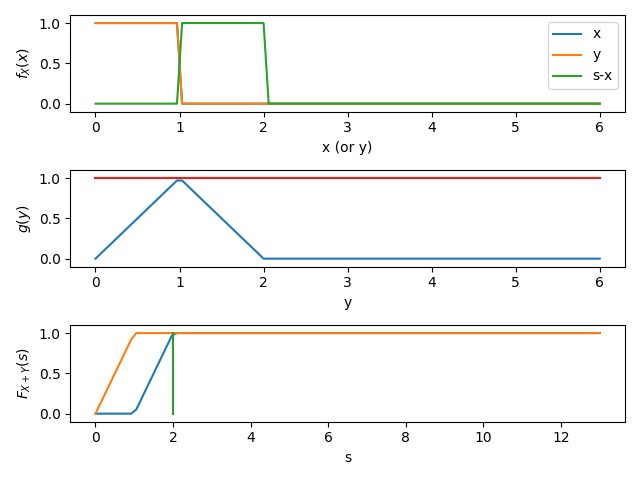

interactive(children=(FloatSlider(value=0.0, description='a_x', max=5.0), FloatSlider(value=1.0, description='…

In [3]:
plot_sum_uniform()

## Optimal Joint Distribution

In [4]:
def copula_lower(a, b, a_x=1, b_x=3, a_y=2, b_y=5, s=1):
    _s_min_lower = np.minimum(a_x+b_y, a_y+b_x)
    rv_s_lower = stats.uniform(loc=_s_min_lower, scale=b_x+b_y-_s_min_lower)
    t = rv_s_lower.cdf(s)
    print(t)
    c = np.minimum(a, b)
    idx_t = np.where(np.logical_and(a >= t, b >= t))
    c[idx_t] = np.maximum(a[idx_t] + b[idx_t] - 1, t)
    return c

def copula_upper(a, b, a_x=1, b_x=3, a_y=2, b_y=5, s=1):
    _s_min_upper = a_x+a_y
    _s_max_upper = np.maximum(a_x+b_y, a_y+b_x)
    rv_s_upper = stats.uniform(loc=_s_min_upper, scale=_s_max_upper-_s_min_upper)
    r = rv_s_upper.cdf(s)
    c = np.minimum(a, b)
    idx_r = np.where(np.logical_and(a <= r, b <= r))
    c[idx_r] = np.maximum(a[idx_r] + b[idx_r] - r, 0)
    return c

In [5]:
from matplotlib.gridspec import GridSpec

def plot_joint_dist(copula, title):
    xlim = [0, 4]
    ylim = [0, 6]
    fig = plt.figure(num=title)
    gs = GridSpec(4,4)
    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_x = fig.add_subplot(gs[0,0:3])
    ax_marg_y = fig.add_subplot(gs[1:4,3])
    #ax_joint.set_xlabel("$\\tilde{X}$")
    ax_marg_x.xaxis.tick_top()
    ax_marg_y.yaxis.tick_right()
    x, stepx = np.linspace(*xlim, num=75, retstep=True)
    y, stepy = np.linspace(*ylim, num=75, retstep=True)
    X, Y = np.meshgrid(x, y)
    def update_plot(a_x=1, b_x=3, a_y=2, b_y=5, s=1):
        rv_x = stats.uniform(loc=a_x, scale=b_x-a_x)
        rv_y = stats.uniform(loc=a_y, scale=b_y-a_y)
        marg_cdf_x = rv_x.cdf(X)
        marg_cdf_y = rv_y.cdf(Y)
        joint_cdf = copula(marg_cdf_x, marg_cdf_y, a_x=a_x, b_x=b_x, a_y=a_y, b_y=b_y, s=s)
        _gradx = np.gradient(joint_cdf, stepx, axis=0)
        joint_pdf = np.gradient(_gradx, stepy, axis=1)
        marg_x = rv_x.pdf(x)
        marg_y = rv_y.pdf(y)
        for _ax in [ax_joint, ax_marg_x, ax_marg_y]:
            _ax.clear()
        ax_marg_x.set_xlim(xlim)
        ax_marg_x.set_ylim([0, 1])
        ax_marg_y.set_xlim([0, 1])
        ax_marg_y.set_ylim(ylim)
        ax_joint.set_xlim(xlim)
        ax_joint.set_ylim(ylim)
        ax_joint.set_xlabel("$X$")
        ax_joint.set_ylabel("$Y$")
        ax_joint.pcolormesh(X, Y, joint_pdf, vmin=0)#, vmax=1)
        ax_joint.plot([0, s], [s, 0], 'r-')
        ax_marg_x.plot(x, marg_x)
        ax_marg_y.plot(marg_y, y)
        #fig.canvas.draw_idle()
    interact(update_plot, a_x=(0, 2, .1), b_x=(2.5, 4, .1), a_y=(0, 2, .1), b_y=(3, 6, .1), s=(0, 10, .1))
    #plt.colorbar()

<IPython.core.display.Javascript object>


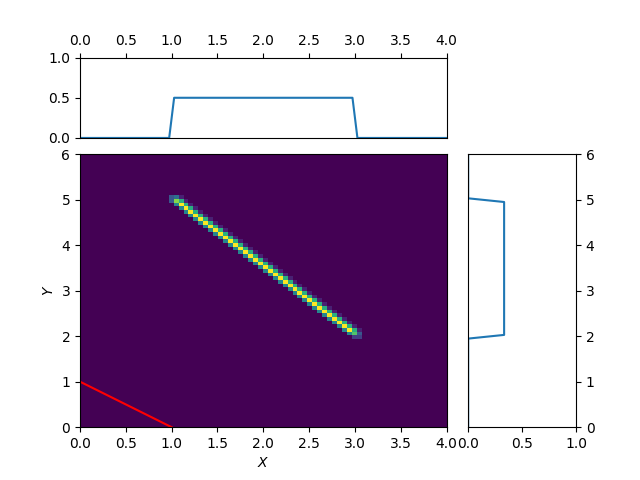

interactive(children=(FloatSlider(value=1.0, description='a_x', max=2.0), FloatSlider(value=3.0, description='…

In [6]:
plot_joint_dist(copula_lower, title="Joint Distribution Lower Bound - Sum Uniform")

<IPython.core.display.Javascript object>


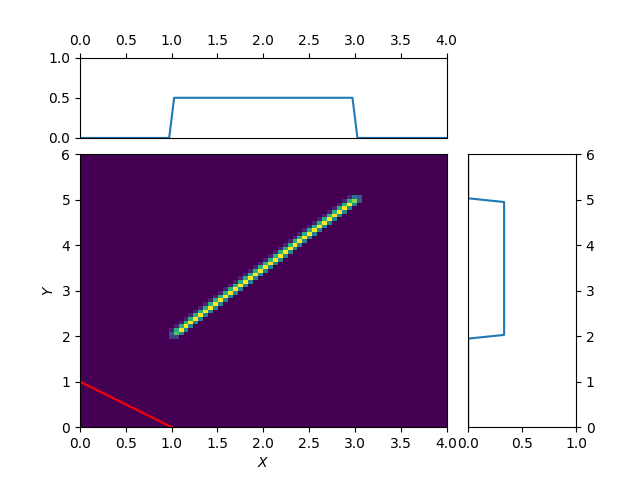

interactive(children=(FloatSlider(value=1.0, description='a_x', max=2.0), FloatSlider(value=3.0, description='…

In [7]:
plot_joint_dist(copula_upper, title="Joint Distribution Upper Bound - Sum Uniform")

# Product of Uniform Random Variables

In [8]:
def _g_product_uniform(y, s, rv_x, rv_y):
    _part1 = np.minimum(rv_x.cdf(s/y)+rv_y.cdf(y), rv_y.cdf(s/y)+rv_x.cdf(y))
    return np.minimum(_part1, 1)

def upper_bound_product_uniform(s, a_x=0, b_x=1, a_y=0, b_y=1):
    rv_x = stats.uniform(loc=a_x, scale=b_x-a_x)
    rv_y = stats.uniform(loc=a_y, scale=b_y-a_y)
    yopt = np.sqrt(s*(b_y-a_y)/(b_x-a_x))
    return np.minimum(_g_product_uniform(yopt, s, rv_x, rv_y), np.minimum(rv_x.cdf(s/a_y), rv_y.cdf(s/a_x)))

def plot_product_uniform():
    x = np.linspace(0.01, 3, 100)
    _s = np.linspace(0.01, 5, 100)
    fig, ax = plt.subplots(3)
    plots = {k: ax[0].plot(x, np.zeros(len(x)), label=k)[0] for k in ["x", "y", "s/x"]}
    plot_g = {k: ax[1].plot(x, np.zeros(len(x)), label=k)[0] for k in ["lower", "upper"]}
    plot_horizontal_cdf_s = {k: ax[1].plot(x, np.zeros(len(x)))[0] for k in ["lower", "upper"]}
    plot_cdf_s = {k: ax[2].plot(_s, np.zeros(len(_s)))[0] for k in ["lower", "upper"]}
    plot_vertical_s = ax[2].plot([1, 1], [0, 1])[0]
    ax[0].set_ylim([-0.1, 1.1])
    ax[1].set_ylim([-.1, 1.1])
    ax[2].set_ylim([-0.1, 1.1])
    ax[0].legend()
    ax[0].set_xlabel("x (or y)")
    ax[0].set_ylabel("$f_{X}(x)$")
    ax[1].set_xlabel("y")
    ax[1].set_ylabel("$g(y)$")
    ax[2].set_xlabel("s")
    ax[2].set_ylabel("$F_{XY}(s)$")
    fig.tight_layout()
    def update_plot(a_x=0, b_x=1, a_y=0, b_y=1, s=2):
        rv_x = stats.uniform(loc=a_x, scale=b_x-a_x)
        rv_y = stats.uniform(loc=a_y, scale=b_y-a_y)
        _s_min_lower = np.minimum(a_x*b_y, a_y*b_x)
        #_s_min_upper = a_x*a_y
        rv_s_lower = stats.uniform(loc=_s_min_lower, scale=b_x*b_y-_s_min_lower)
        yopt = np.sqrt(s*(b_y-a_y)/(b_x-a_x))
        
        plots['x'].set_ydata(rv_x.pdf(x))
        plots['y'].set_ydata(rv_y.pdf(x))
        plots['s/x'].set_ydata(rv_x.pdf(s/x))
        plot_g["lower"].set_ydata(np.maximum(rv_x.cdf(s/x)+rv_y.cdf(x)-1, 0))
        plot_g["upper"].set_ydata(np.minimum(rv_x.cdf(s/x)+rv_y.cdf(x), 1))
        plot_horizontal_cdf_s["lower"].set_ydata(np.maximum(rv_x.cdf(s/b_y), rv_y.cdf(s/b_x)))
        plot_horizontal_cdf_s["upper"].set_ydata(np.minimum(_g_product_uniform(yopt, s, rv_x, rv_y),
                                                            np.minimum(rv_x.cdf(s/a_y), rv_y.cdf(s/a_x))))
        plot_cdf_s["lower"].set_ydata(rv_s_lower.cdf(_s))
        plot_cdf_s["upper"].set_ydata(upper_bound_product_uniform(_s, a_x, b_x, a_y, b_y))
        plot_vertical_s.set_xdata([s, s])
    #interact(update_plot, a_x=(0, 5, .1), a_y=(0, 5, .1), s=(0, 12, .1))
    interact(update_plot, a_x=(0.01, 2, .1), b_x=(0.01, 2, .1), a_y=(0.01, 2, .1), b_y=(0.01, 2, .1),
             s=(0.01, 11, .1))

<IPython.core.display.Javascript object>


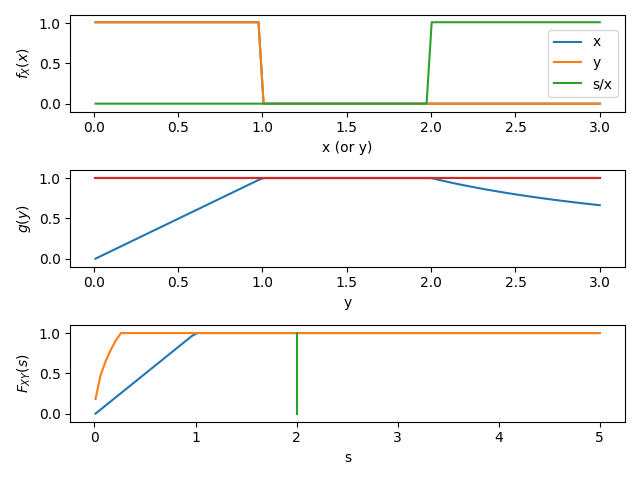

interactive(children=(FloatSlider(value=0.01, description='a_x', max=2.0, min=0.01), FloatSlider(value=1.0, de…

In [9]:
plot_product_uniform()